In [1]:
import pandas as pd
import numpy as np

# Tools for recursive feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Tools for fitting logistic regression and getting p-values
import statsmodels.api as sm

# For plotting
import matplotlib.pyplot as plt

# Our local, useful functions
from baseball_utils import *

In [2]:
# Read in the scraped, merged dataframe
cp_df = pd.read_csv("cp_merged.csv")
cp_df.head(10)

,count,home_pitcher,inning,run_diff,strike_given_called,pitcher_race,umpire_race
0,0-0,1,1,0,True,white,white
1,0-0,1,1,0,False,white,white
2,1-1,1,1,0,True,white,white
3,1-2,1,1,0,False,white,white
4,0-0,1,1,0,False,white,white
5,1-1,1,1,0,False,white,white
6,0-2,0,1,0,False,white,white
7,1-2,0,1,0,False,white,white
8,0-0,0,1,0,True,white,white
9,0-2,0,1,0,True,white,white


## Overall notes on data

## Analysis of logistic regression for all data
* p-value for UPM coefficient is large (0.239) indicating lack of significance
* effect of UPM coefficient is small (were it to be considered significant, it would indicate that the umpire was only 0.1% more likely to call a strike when the pitcher matched on race)
* It is interesting to note that the magnitude of $\beta_1$ (where $\beta_1$ denotes the UPM coefficient) decreases as more control features are removes; at the same time as $|\beta_1|$ decreases, the $p$-value increases. This effect can be seen for most of the following subset analyses for when the umpire's race is held constant.

In [3]:
# Prepare the data for fitting
%time X, y = prepare_df(cp_df)

/Users/robertair2019/Desktop/upm/baseball_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['strike_given_called'] = df['strike_given_called'].apply(int)
/Users/robertair2019/Desktop/upm/baseball_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['upm'] = df.apply(lambda x: x.pitcher_race==x.umpire_race, axis=1).apply(int)


CPU times: user 37.6 s, sys: 381 ms, total: 38 s
Wall time: 38 s


In [4]:
# Fit logistic regression on data
fit = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.580795
         Iterations 6


In [5]:
# Show summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     strike_given_called   No. Observations:              1136496
Model:                           Logit   Df Residuals:                  1136473
Method:                            MLE   Df Model:                           22
Date:                 Sat, 13 Jul 2019   Pseudo R-squ.:                 0.08250
Time:                         14:38:59   Log-Likelihood:            -6.6007e+05
converged:                        True   LL-Null:                   -7.1942e+05
                                         LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
upm              0.0051      0.004      1.177      0.239      -0.003       0.014
home_pitcher     0.0445      0.004     10.536      0.000       0.036       0.053
run_diff         0.0151      0.001     21.209      0.000       0.014       0.017
count_0-1       -1.1167      0.007   -156.696      0.000      -1.131      -1.103
count_0-2       -2.2604      0.014   -156.204      0.000      -2.289      -2.232
count_1-0       -0.1644      0.007    -25.165      0.000      -0.177      -0.152
count_1-1       -0.9228      0.008   -116.058      0.000      -0.938      -0.907
count_1-2       -2.0133      0.012   -169.233      0.000      -2.037      -1.990
count_2-0        0.0382      0.010      3.709      0.000       0.018       0.058
count_2-1       -0.7035      0.011    -64.945      0.000      -0.725      -0.682
count_2-2       -1.6241      0.012   -131.760      0.000      -1.648      -1.600
count_3-0        0.7767      0.015     51.535      0.000       0.747       0.806
count_3-1       -0.2918      0.015    -19.558      0.000      -0.321      -0.263
count_3-2       -1.2840      0.016    -79.278      0.000      -1.316      -1.252
inning_2         0.0141      0.009      1.638      0.101      -0.003       0.031
inning_3        -0.0195      0.009     -2.254      0.024      -0.036      -0.003
inning_4        -0.1033      0.009    -11.830      0.000      -0.120      -0.086
inning_5        -0.0851      0.009     -9.739      0.000      -0.102      -0.068
inning_6        -0.1374      0.009    -15.670      0.000      -0.155      -0.120
inning_7        -0.1003      0.009    -11.462      0.000      -0.117      -0.083
inning_8        -0.0846      0.009     -9.649      0.000      -0.102      -0.067
inning_9+       -0.0593      0.009     -6.701      0.000      -0.077      -0.042
intercept       -0.1392      0.007    -19.074      0.000      -0.153      -0.125
================================================================================
"""

### Calculate effect of UPM
Let $\sigma(\mathbf{x})$ denote the logistic regression fit for the data, where $$\sigma(x_1, x_2, \dots) = \frac{1}{1 + e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots}}.$$

We quantify the effect that umpire and pitcher matching on race (UPM) has by evaluating 
$\frac{\partial\sigma}{\partial x_1}$ at $x_1 = 0$, $x_i = \bar{x}_i$ for $i > 1$.

In [6]:
# Calculate the effect of UPM; in this case, it is small (0.1% more likely to call a strike)
# and insignificant (p-value = 0.239). Hence, we fail to reject the null hypothesis that umpire and pitcher matching on race has an effect on whether or not the umpire calls a strike
upm_effects(fit, X)

0.0010851791079812992

### Examine feature importance and effect of including control features

In [7]:
%time ranked_features = rank_features(X, y)

CPU times: user 42.6 s, sys: 2.9 s, total: 45.5 s
Wall time: 38.4 s


In [8]:
# Features in descending rank of significance
ranked_features

['count_0-2',
 'count_1-2',
 'count_2-2',
 'count_3-0',
 'count_3-2',
 'count_0-1',
 'count_1-1',
 'count_2-1',
 'count_3-1',
 'count_1-0',
 'inning_6',
 'inning_4',
 'inning_7',
 'inning_5',
 'inning_8',
 'inning_9+',
 'home_pitcher',
 'count_2-0',
 'inning_3',
 'run_diff',
 'inning_2',
 'upm']

In [9]:
# Calculate UPM coefficients and associated p-values when control features are removed, starting with least significant to most significant
%time nf, beta, p = eliminate_features(X, y, ranked_features)

Fitting 22 variables...
Optimization terminated successfully.
         Current function value: 0.580795
         Iterations 6
Beta = 0.0051387482643888574; p = 0.23900622040607855
Fitting 21 variables...
Optimization terminated successfully.
         Current function value: 0.580797
         Iterations 6
Beta = 0.005152675106252487; p = 0.2377343267982288
Fitting 20 variables...
Optimization terminated successfully.
         Current function value: 0.580995
         Iterations 6
Beta = 0.005331898719088635; p = 0.2217071971083846
Fitting 19 variables...
Optimization terminated successfully.
         Current function value: 0.581000
         Iterations 6
Beta = 0.0053208986178373986; p = 0.22265898791676864
Fitting 18 variables...
Optimization terminated successfully.
         Current function value: 0.581006
         Iterations 6
Beta = 0.005289272828990819; p = 0.2254160157908779
Fitting 17 variables...
Optimization terminated successfully.
         Current function value: 0.581044
  

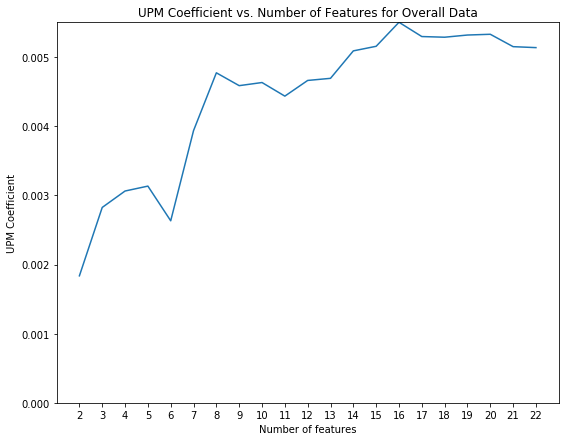

In [10]:
# Plot UPM coefficients against number of features
plot_beta(beta, nf, "UPM Coefficient vs. Number of Features for Overall Data", "upm_vs_nf_overall.png")

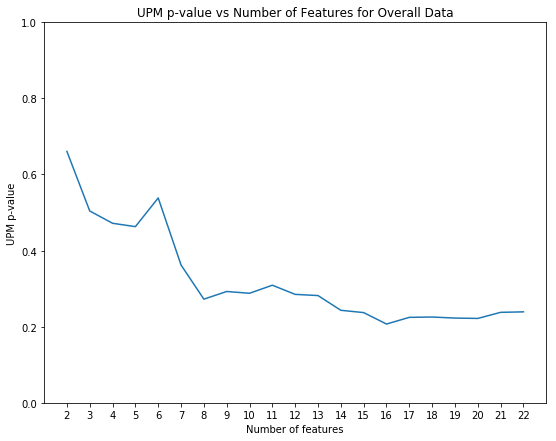

In [11]:
# Plot associated p values against number of features
plot_pvalues(p, nf, "UPM p-value vs Number of Features for Overall Data", "p_vs_nf_overall.png")

## Analysis of logistic regression when umpire is white
* $p = 0.275$
* Observed effect of UPM is small (umpire +0.1% more likely to call strike if pitcher is also white when all else held at average)
* Fail to conclude any significant effect from findings.

In [12]:
white_umpire = cp_df[cp_df.umpire_race == 'white']
%time X_white, y_white = prepare_df(white_umpire)

/Users/robertair2019/Desktop/upm/baseball_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['strike_given_called'] = df['strike_given_called'].apply(int)
/Users/robertair2019/Desktop/upm/baseball_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['upm'] = df.apply(lambda x: x.pitcher_race==x.umpire_race, axis=1).apply(int)


CPU times: user 32.8 s, sys: 358 ms, total: 33.2 s
Wall time: 33.1 s


In [13]:
fit_white = sm.Logit(y_white, X_white).fit()

Optimization terminated successfully.
         Current function value: 0.581129
         Iterations 6


In [14]:
fit_white.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     strike_given_called   No. Observations:              1011460
Model:                           Logit   Df Residuals:                  1011437
Method:                            MLE   Df Model:                           22
Date:                 Sat, 13 Jul 2019   Pseudo R-squ.:                 0.08224
Time:                         14:42:01   Log-Likelihood:            -5.8779e+05
converged:                        True   LL-Null:                   -6.4046e+05
                                         LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
upm              0.0053      0.005      1.091      0.275      -0.004       0.015
home_pitcher     0.0456      0.004     10.181      0.000       0.037       0.054
run_diff         0.0158      0.001     20.676      0.000       0.014       0.017
count_0-1       -1.1127      0.008   -147.460      0.000      -1.128      -1.098
count_0-2       -2.2577      0.015   -147.383      0.000      -2.288      -2.228
count_1-0       -0.1649      0.007    -23.815      0.000      -0.178      -0.151
count_1-1       -0.9210      0.008   -109.326      0.000      -0.938      -0.904
count_1-2       -2.0140      0.013   -159.614      0.000      -2.039      -1.989
count_2-0        0.0349      0.011      3.195      0.001       0.013       0.056
count_2-1       -0.7008      0.011    -61.043      0.000      -0.723      -0.678
count_2-2       -1.6175      0.013   -124.061      0.000      -1.643      -1.592
count_3-0        0.7688      0.016     48.219      0.000       0.738       0.800
count_3-1       -0.2912      0.016    -18.402      0.000      -0.322      -0.260
count_3-2       -1.2888      0.017    -75.001      0.000      -1.322      -1.255
inning_2         0.0146      0.009      1.595      0.111      -0.003       0.032
inning_3        -0.0288      0.009     -3.145      0.002      -0.047      -0.011
inning_4        -0.1038      0.009    -11.214      0.000      -0.122      -0.086
inning_5        -0.0878      0.009     -9.478      0.000      -0.106      -0.070
inning_6        -0.1408      0.009    -15.165      0.000      -0.159      -0.123
inning_7        -0.1027      0.009    -11.081      0.000      -0.121      -0.085
inning_8        -0.0843      0.009     -9.073      0.000      -0.103      -0.066
inning_9+       -0.0600      0.009     -6.397      0.000      -0.078      -0.042
intercept       -0.1376      0.008    -17.393      0.000      -0.153      -0.122
================================================================================
"""

In [15]:
# +0.1% effect when all else is held at average
upm_effects(fit_white, X_white)

0.0011165217354785766

### Rank features and examine effect of adding/removing control features

In [16]:
%time rf_white = rank_features(X_white, y_white)

CPU times: user 38.8 s, sys: 2.51 s, total: 41.3 s
Wall time: 34.8 s


In [17]:
rf_white

['count_0-2',
 'count_1-2',
 'count_2-2',
 'count_3-0',
 'count_3-2',
 'count_0-1',
 'count_1-1',
 'count_2-1',
 'count_3-1',
 'count_1-0',
 'inning_6',
 'inning_4',
 'inning_7',
 'inning_5',
 'inning_8',
 'inning_9+',
 'home_pitcher',
 'inning_3',
 'count_2-0',
 'run_diff',
 'inning_2',
 'upm']

In [18]:
# Graph UPM coefficients and p-values against number of features
%time nf_white, beta_white, p_white = eliminate_features(X_white, y_white, rf_white)

Fitting 22 variables...
Optimization terminated successfully.
         Current function value: 0.581129
         Iterations 6
Beta = 0.005284723250301279; p = 0.2754771485067118
Fitting 21 variables...
Optimization terminated successfully.
         Current function value: 0.581130
         Iterations 6
Beta = 0.0053008685114982; p = 0.27401162039038596
Fitting 20 variables...
Optimization terminated successfully.
         Current function value: 0.581342
         Iterations 6
Beta = 0.005502913621090046; p = 0.25603127399434567
Fitting 19 variables...
Optimization terminated successfully.
         Current function value: 0.581346
         Iterations 6
Beta = 0.005462192759870462; p = 0.25956117157570935
Fitting 18 variables...
Optimization terminated successfully.
         Current function value: 0.581356
         Iterations 6
Beta = 0.005470113657616598; p = 0.25886545946312467
Fitting 17 variables...
Optimization terminated successfully.
         Current function value: 0.581396
    

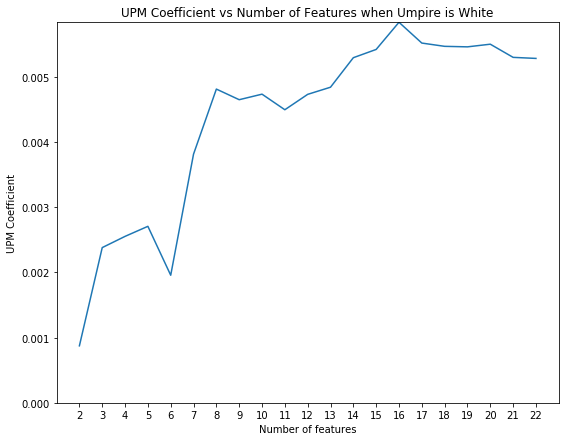

In [19]:
plot_beta(beta_white, nf_white, "UPM Coefficient vs Number of Features when Umpire is White", "upm_vs_nf_white_umpire.png")

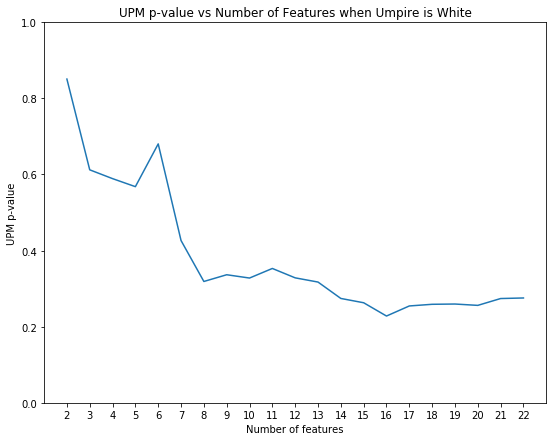

In [20]:
plot_pvalues(p_white, nf_white, "UPM p-value vs Number of Features when Umpire is White", "p_vs_nf_white_umpire.png")

## Analysis of logistic regression when umpire is black
* $p = 0.049$
* Umpire is 1.4% less likely to call a strike when the pitcher is also black

In [21]:
black_umpire = cp_df[cp_df.umpire_race == 'black']
%time X_black, y_black = prepare_df(black_umpire)

CPU times: user 2.62 s, sys: 42.7 ms, total: 2.66 s
Wall time: 2.69 s


In [22]:
fit_black = sm.Logit(y_black, X_black).fit()

Optimization terminated successfully.
         Current function value: 0.578704
         Iterations 6


In [23]:
fit_black.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     strike_given_called   No. Observations:                70230
Model:                           Logit   Df Residuals:                    70207
Method:                            MLE   Df Model:                           22
Date:                 Sat, 13 Jul 2019   Pseudo R-squ.:                 0.08512
Time:                         14:46:57   Log-Likelihood:                -40642.
converged:                        True   LL-Null:                       -44424.
                                         LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
upm             -0.0675      0.034     -1.968      0.049      -0.135      -0.000
home_pitcher    -0.0046      0.017     -0.268      0.789      -0.038       0.029
run_diff         0.0075      0.003      2.749      0.006       0.002       0.013
count_0-1       -1.1575      0.029    -39.992      0.000      -1.214      -1.101
count_0-2       -2.2820      0.059    -38.712      0.000      -2.397      -2.166
count_1-0       -0.1475      0.026     -5.613      0.000      -0.199      -0.096
count_1-1       -0.9792      0.032    -30.320      0.000      -1.042      -0.916
count_1-2       -2.0222      0.048    -42.087      0.000      -2.116      -1.928
count_2-0        0.0759      0.042      1.820      0.069      -0.006       0.158
count_2-1       -0.7499      0.043    -17.303      0.000      -0.835      -0.665
count_2-2       -1.6533      0.050    -32.788      0.000      -1.752      -1.554
count_3-0        0.8049      0.062     13.037      0.000       0.684       0.926
count_3-1       -0.2210      0.059     -3.766      0.000      -0.336      -0.106
count_3-2       -1.2556      0.064    -19.638      0.000      -1.381      -1.130
inning_2         0.0626      0.035      1.810      0.070      -0.005       0.130
inning_3         0.0556      0.035      1.589      0.112      -0.013       0.124
inning_4        -0.1294      0.035     -3.665      0.000      -0.199      -0.060
inning_5        -0.0103      0.035     -0.292      0.771      -0.079       0.059
inning_6        -0.0585      0.036     -1.640      0.101      -0.128       0.011
inning_7        -0.0761      0.036     -2.142      0.032      -0.146      -0.006
inning_8        -0.0429      0.035     -1.218      0.223      -0.112       0.026
inning_9+       -0.0246      0.036     -0.691      0.489      -0.094       0.045
intercept       -0.1427      0.027     -5.222      0.000      -0.196      -0.089
================================================================================
"""

In [24]:
upm_effects(fit_black, X_black)

-0.014269306648078845

### Rank features and examine effect of adding/removing control features

In [25]:
rf_black = rank_features(X_black, y_black)

In [26]:
rf_black

['count_0-2',
 'count_1-2',
 'count_2-2',
 'count_3-2',
 'count_0-1',
 'count_1-1',
 'count_3-0',
 'count_2-1',
 'count_3-1',
 'count_1-0',
 'inning_4',
 'inning_2',
 'inning_3',
 'count_2-0',
 'upm',
 'inning_7',
 'inning_6',
 'inning_8',
 'inning_9+',
 'inning_5',
 'run_diff',
 'home_pitcher']

In [27]:
%time nf_black, beta_black, p_black = eliminate_features(X_black, y_black, rf_black)

Fitting 22 variables...
Optimization terminated successfully.
         Current function value: 0.578704
         Iterations 6
Beta = -0.0675343695363255; p = 0.04903395246543318
Fitting 21 variables...
Optimization terminated successfully.
         Current function value: 0.578704
         Iterations 6
Beta = -0.06737452819173258; p = 0.049538448501249784
Fitting 20 variables...
Optimization terminated successfully.
         Current function value: 0.578759
         Iterations 6
Beta = -0.06796976317231496; p = 0.0475370954433381
Fitting 19 variables...
Optimization terminated successfully.
         Current function value: 0.578760
         Iterations 6
Beta = -0.06801613885516661; p = 0.0473829505205933
Fitting 18 variables...
Optimization terminated successfully.
         Current function value: 0.578761
         Iterations 6
Beta = -0.06935246210914332; p = 0.04235155662626886
Fitting 17 variables...
Optimization terminated successfully.
         Current function value: 0.578771
   

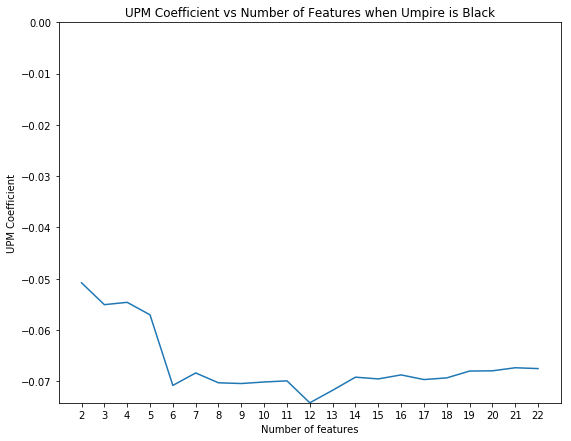

In [28]:
plot_beta(beta_black, nf_black, "UPM Coefficient vs Number of Features when Umpire is Black", "upm_vs_nf_black_umpire.png")

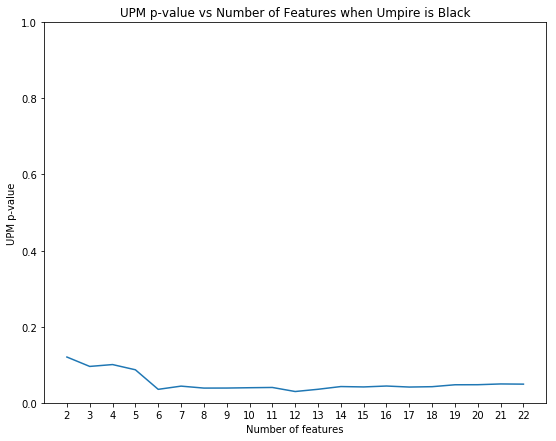

In [29]:
plot_pvalues(p_black, nf_black, "UPM p-value vs Number of Features when Umpire is Black", "p_vs_nf_black_umpire.png")

## Analysis of logistic regression for hispanic umpire
* $p = 0.860$
* Nothing remotely significant observed - UPM effect nearly zero.

In [30]:
hispanic_umpire = cp_df[cp_df.umpire_race == 'hispanic']
hispanic_umpire.head()

,count,home_pitcher,inning,run_diff,strike_given_called,pitcher_race,umpire_race
2642,0-0,1,1,0,False,white,hispanic
2643,1-0,1,1,0,True,white,hispanic
2644,1-1,1,1,0,False,white,hispanic
2645,0-1,1,1,0,False,white,hispanic
2646,0-0,1,1,0,False,white,hispanic


In [31]:
%time X_hispanic, y_hispanic = prepare_df(hispanic_umpire)

CPU times: user 1.82 s, sys: 21.4 ms, total: 1.84 s
Wall time: 1.87 s


In [32]:
fit_hispanic = sm.Logit(y_hispanic, X_hispanic).fit()

Optimization terminated successfully.
         Current function value: 0.576493
         Iterations 6


In [33]:
fit_hispanic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     strike_given_called   No. Observations:                54806
Model:                           Logit   Df Residuals:                    54783
Method:                            MLE   Df Model:                           22
Date:                 Sat, 13 Jul 2019   Pseudo R-squ.:                 0.08525
Time:                         14:47:07   Log-Likelihood:                -31595.
converged:                        True   LL-Null:                       -34540.
                                         LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
upm             -0.0042      0.024     -0.177      0.860      -0.051       0.042
home_pitcher     0.0860      0.019      4.454      0.000       0.048       0.124
run_diff         0.0138      0.003      4.571      0.000       0.008       0.020
count_0-1       -1.1425      0.033    -34.896      0.000      -1.207      -1.078
count_0-2       -2.2907      0.067    -34.409      0.000      -2.421      -2.160
count_1-0       -0.1749      0.030     -5.858      0.000      -0.233      -0.116
count_1-1       -0.8861      0.036    -24.543      0.000      -0.957      -0.815
count_1-2       -1.9931      0.053    -37.369      0.000      -2.098      -1.889
count_2-0        0.0596      0.047      1.264      0.206      -0.033       0.152
count_2-1       -0.6914      0.050    -13.851      0.000      -0.789      -0.594
count_2-2       -1.7127      0.057    -29.911      0.000      -1.825      -1.600
count_3-0        0.9074      0.070     12.985      0.000       0.770       1.044
count_3-1       -0.3923      0.069     -5.668      0.000      -0.528      -0.257
count_3-2       -1.2339      0.074    -16.569      0.000      -1.380      -1.088
inning_2        -0.0553      0.039     -1.401      0.161      -0.133       0.022
inning_3         0.0617      0.039      1.571      0.116      -0.015       0.139
inning_4        -0.0609      0.040     -1.539      0.124      -0.138       0.017
inning_5        -0.1284      0.040     -3.233      0.001      -0.206      -0.051
inning_6        -0.1735      0.040     -4.311      0.000      -0.252      -0.095
inning_7        -0.0822      0.040     -2.060      0.039      -0.160      -0.004
inning_8        -0.1388      0.040     -3.457      0.001      -0.218      -0.060
inning_9+       -0.0847      0.041     -2.073      0.038      -0.165      -0.005
intercept       -0.1595      0.031     -5.114      0.000      -0.221      -0.098
================================================================================
"""

In [34]:
upm_effects(fit_hispanic, X_hispanic)

-0.0008780771860644173

## Rank features and examine effect of adding/removing control features

In [35]:
rf_hispanic = rank_features(X_hispanic, y_hispanic)

In [36]:
rf_hispanic

['count_0-2',
 'count_1-2',
 'count_2-2',
 'count_3-0',
 'count_3-2',
 'count_0-1',
 'count_1-1',
 'count_2-1',
 'count_3-1',
 'count_1-0',
 'inning_3',
 'inning_6',
 'home_pitcher',
 'inning_8',
 'inning_5',
 'count_2-0',
 'inning_7',
 'inning_9+',
 'inning_4',
 'inning_2',
 'run_diff',
 'upm']

In [37]:
%time nf_hispanic, beta_hispanic, p_hispanic = eliminate_features(X_hispanic, y_hispanic, rf_hispanic)

Fitting 22 variables...
Optimization terminated successfully.
         Current function value: 0.576493
         Iterations 6
Beta = -0.0041892206799233975; p = 0.8595409313543707
Fitting 21 variables...
Optimization terminated successfully.
         Current function value: 0.576684
         Iterations 6
Beta = -0.00392317129230092; p = 0.8683529577985332
Fitting 20 variables...
Optimization terminated successfully.
         Current function value: 0.576701
         Iterations 6
Beta = -0.00416986417261148; p = 0.8601520526070399
Fitting 19 variables...
Optimization terminated successfully.
         Current function value: 0.576710
         Iterations 6
Beta = -0.003994959818704232; p = 0.8659561463000154
Fitting 18 variables...
Optimization terminated successfully.
         Current function value: 0.576717
         Iterations 6
Beta = -0.004289784305280286; p = 0.8561549211229252
Fitting 17 variables...
Optimization terminated successfully.
         Current function value: 0.576731
  

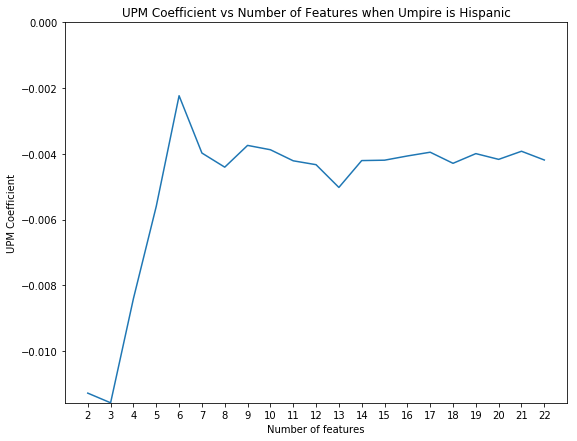

In [38]:
plot_beta(beta_hispanic, nf_hispanic, "UPM Coefficient vs Number of Features when Umpire is Hispanic", "upm_vs_nf_hispanic_umpire.png")

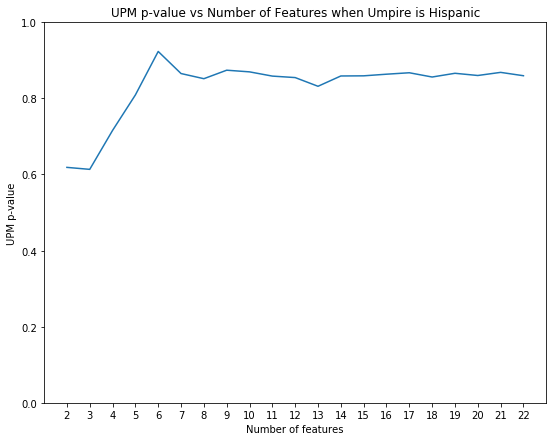

In [39]:
plot_pvalues(p_hispanic, nf_hispanic, "UPM p-value vs Number of Features when Umpire is Hispanic", "p_vs_nf_hispanic_umpire.png")

## Analysis of logistic regression when umpire is nonwhite
* Here, we lump the races into two categories: white vs nonwhite. We examine the effect of whether or not the umpire and pitcher match on nonwhiteness
* $p = 0.088$
* Observed effect is that a nonwhite umpire is 0.5% less likely to call a strike when the pitcher is also not white, when all else is held at its mean.

In [40]:
w_nw_df = cp_df.copy()
w_nw_df.umpire_race = w_nw_df.umpire_race.apply(white_or_not)
w_nw_df.pitcher_race = w_nw_df.pitcher_race.apply(white_or_not)
nonwhite_umpire = w_nw_df[w_nw_df.umpire_race == 'nonwhite']
nonwhite_umpire.head()

,count,home_pitcher,inning,run_diff,strike_given_called,pitcher_race,umpire_race
2642,0-0,1,1,0,False,white,nonwhite
2643,1-0,1,1,0,True,white,nonwhite
2644,1-1,1,1,0,False,white,nonwhite
2645,0-1,1,1,0,False,white,nonwhite
2646,0-0,1,1,0,False,white,nonwhite


In [41]:
%time X_nonwhite, y_nonwhite = prepare_df(nonwhite_umpire)

CPU times: user 5.02 s, sys: 75.8 ms, total: 5.1 s
Wall time: 5.05 s


In [42]:
fit_nonwhite = sm.Logit(y_nonwhite, X_nonwhite).fit()

Optimization terminated successfully.
         Current function value: 0.577946
         Iterations 6


In [43]:
fit_nonwhite.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     strike_given_called   No. Observations:               125036
Model:                           Logit   Df Residuals:                   125013
Method:                            MLE   Df Model:                           22
Date:                 Sat, 13 Jul 2019   Pseudo R-squ.:                 0.08485
Time:                         14:47:20   Log-Likelihood:                -72264.
converged:                        True   LL-Null:                       -78964.
                                         LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
upm             -0.0237      0.014     -1.708      0.088      -0.051       0.004
home_pitcher     0.0361      0.013      2.827      0.005       0.011       0.061
run_diff         0.0106      0.002      5.250      0.000       0.007       0.015
count_0-1       -1.1499      0.022    -53.039      0.000      -1.192      -1.107
count_0-2       -2.2840      0.044    -51.758      0.000      -2.370      -2.197
count_1-0       -0.1603      0.020     -8.129      0.000      -0.199      -0.122
count_1-1       -0.9375      0.024    -38.962      0.000      -0.985      -0.890
count_1-2       -2.0080      0.036    -56.258      0.000      -2.078      -1.938
count_2-0        0.0661      0.031      2.119      0.034       0.005       0.127
count_2-1       -0.7251      0.033    -22.163      0.000      -0.789      -0.661
count_2-2       -1.6792      0.038    -44.383      0.000      -1.753      -1.605
count_3-0        0.8446      0.046     18.268      0.000       0.754       0.935
count_3-1       -0.2953      0.045     -6.607      0.000      -0.383      -0.208
count_3-2       -1.2457      0.049    -25.685      0.000      -1.341      -1.151
inning_2         0.0111      0.026      0.427      0.669      -0.040       0.062
inning_3         0.0577      0.026      2.210      0.027       0.007       0.109
inning_4        -0.0992      0.026     -3.765      0.000      -0.151      -0.048
inning_5        -0.0627      0.026     -2.378      0.017      -0.114      -0.011
inning_6        -0.1098      0.027     -4.114      0.000      -0.162      -0.057
inning_7        -0.0809      0.027     -3.050      0.002      -0.133      -0.029
inning_8        -0.0862      0.026     -3.257      0.001      -0.138      -0.034
inning_9+       -0.0522      0.027     -1.950      0.051      -0.105       0.000
intercept       -0.1455      0.021     -6.988      0.000      -0.186      -0.105
================================================================================
"""

In [44]:
upm_effects(fit_nonwhite, X_nonwhite)

-0.005006611028762808

### Rank features and examine effect of adding/removing control features

In [45]:
rf_nonwhite = rank_features(X_nonwhite, y_nonwhite)

In [46]:
rf_nonwhite

['count_0-2',
 'count_1-2',
 'count_2-2',
 'count_3-0',
 'count_3-2',
 'count_0-1',
 'count_1-1',
 'count_2-1',
 'count_3-1',
 'count_1-0',
 'inning_3',
 'count_2-0',
 'inning_6',
 'inning_4',
 'inning_8',
 'inning_7',
 'inning_5',
 'inning_9+',
 'home_pitcher',
 'upm',
 'inning_2',
 'run_diff']

In [47]:
%time nf_nonwhite, beta_nonwhite, p_nonwhite = eliminate_features(X_nonwhite, y_nonwhite, rf_nonwhite)

Fitting 22 variables...
Optimization terminated successfully.
         Current function value: 0.577946
         Iterations 6
Beta = -0.02373526488655271; p = 0.08765412973912415
Fitting 21 variables...
Optimization terminated successfully.
         Current function value: 0.578056
         Iterations 6
Beta = -0.02326483514238061; p = 0.09407965954696025
Fitting 20 variables...
Optimization terminated successfully.
         Current function value: 0.578057
         Iterations 6
Beta = -0.023234616969380357; p = 0.09450340107791404
Fitting 19 variables...
Optimization terminated successfully.
         Current function value: 0.578083
         Iterations 6
Beta = -0.023469910223820813; p = 0.09119590195145472
Fitting 18 variables...
Optimization terminated successfully.
         Current function value: 0.578096
         Iterations 6
Beta = -0.024278045098361355; p = 0.08043126992485021
Fitting 17 variables...
Optimization terminated successfully.
         Current function value: 0.57812

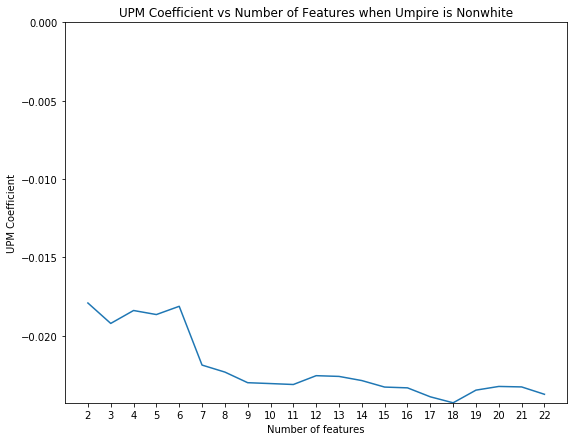

In [48]:
plot_beta(beta_nonwhite, nf_nonwhite, "UPM Coefficient vs Number of Features when Umpire is Nonwhite", "upm_vs_nf_nonwhite_umpire.png")

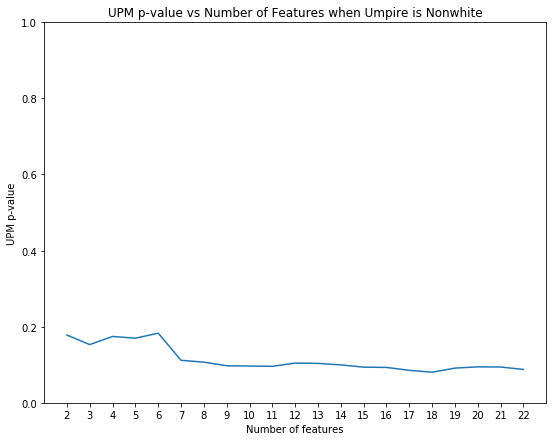

In [49]:
plot_pvalues(p_nonwhite, nf_nonwhite, "UPM p-value vs Number of Features when Umpire is Nonwhite", "p_vs_nf_nonwhite_umpire.png")